In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import open3d as o3d
from torch.utils.data import DataLoader
from learning3d.data_utils import ClassificationData, ModelNet40Data
from model_conv1d import Encoder, PPFFoldNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ModelNet40 veri kümesini yükleme
train_dataset = ClassificationData(data_class=ModelNet40Data(train=True, num_points=2048, use_normals=False))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

test_dataset = ClassificationData(data_class=ModelNet40Data(train=False, num_points=2048, use_normals=False))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


def augment(points):
    """Veri artırma işlemi uygular: Döndürme ve gürültü ekleme."""
    noise = torch.randn_like(points) * 0.03  # Gürültü ekle
    angles = torch.rand(3) * 2 * torch.pi  # 3 eksende rastgele döndür
    
    Rx = torch.tensor([[1, 0, 0],
                       [0, torch.cos(angles[0]), -torch.sin(angles[0])],
                       [0, torch.sin(angles[0]), torch.cos(angles[0])]])
    
    Ry = torch.tensor([[torch.cos(angles[1]), 0, torch.sin(angles[1])],
                       [0, 1, 0],
                       [-torch.sin(angles[1]), 0, torch.cos(angles[1])]])
    
    Rz = torch.tensor([[torch.cos(angles[2]), -torch.sin(angles[2]), 0],
                       [torch.sin(angles[2]), torch.cos(angles[2]), 0],
                       [0, 0, 1]])
    
    rotation_matrix = Rz @ Ry @ Rx
    rotation_matrix = rotation_matrix.to(points.device)

    # İlk 3 kanal koordinatlar (B, N, 3), son 3 kanal normaller (B, N, 3)
    xyz = points[:, :, :3]  # (B, N, 3) - Nokta koordinatları
    normals = points[:, :, 3:]  # (B, N, 3) - Normal vektörleri
    
    # Döndürme işlemi sadece koordinatlara uygulanır
    xyz_rotated = torch.matmul(xyz, rotation_matrix.T)
    normals_rotated = torch.matmul(normals, rotation_matrix.T)  # Normaller de döndürülmeli

    # Gürültüyü sadece koordinatlara ekleyelim
    xyz_augmented = xyz_rotated + noise[:, :, :3]  

    # Tekrar birleştir
    points_augmented = torch.cat((xyz_augmented, normals_rotated), dim=-1)
    
    return points_augmented


class PointCloudNormalizer(nn.Module):
    def __init__(self):
        super(PointCloudNormalizer, self).__init__()

    def forward(self, x):
        """
        Input: x -> (B, N, 6)  -> (x, y, z, nx, ny, nz)
        Output: out -> (B, N, 4) -> (x, y, z, norm_magnitude)
        """
        xyz = x[:, :, :3]  # (B, N, 3) - x, y, z koordinatları
        normals = x[:, :, 3:]  # (B, N, 3) - normal vektörleri
        
        # Normallerin büyüklüğünü hesapla (L2 normu)
        norm_magnitude = torch.norm(normals, dim=2, keepdim=True)  # (B, N, 1)

        # Yeni tensörü oluştur (x, y, z, norm büyüklüğü)
        out = torch.cat((xyz, norm_magnitude), dim=2)  # (B, N, 4)
        return out


class EncoderHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super(EncoderHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.norm2 = nn.BatchNorm1d(output_dim)  # Yeni ekleme

    def forward(self, x):
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.norm2(x)  # Yeni ekleme
        return x



class PPFFoldNetEncoder(nn.Module):
    """Tüm modelleri birleştiren encoder"""
    def __init__(self, input_dim=6, hidden_dim=512, output_dim=128):
        super(PPFFoldNetEncoder, self).__init__()
        #self.normalizer = PointCloudNormalizer()
        self.base = Encoder(num_points_per_patch=2048)
        self.head = EncoderHead(512, 256, 128)

    def forward(self, x):
        #x = self.normalizer(x)
        x = self.base(x)
        x = torch.squeeze(x)
        x = self.head(x)
        return x

encoder_model = PPFFoldNetEncoder().to("cuda")


class PPFFoldNetClassifier(nn.Module):
    def __init__(self, num_classes=40, embedding_dim=128):
        super(PPFFoldNetClassifier, self).__init__()
        self.encoder = encoder_model
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.4),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3),

            nn.Linear(512, num_classes)
        )
    
    def forward(self, points):
        features = self.encoder(points)
        global_embedding = features.squeeze()
        logits = self.fc(global_embedding)
        return logits

model = PPFFoldNetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

num_epochs = 100
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0
    for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        points, labels = data
        points = (points - points.mean(dim=1, keepdim=True)) / torch.max(torch.norm(points, dim=-1, keepdim=True))
        points = points.to(device, dtype=torch.float32)
        labels = labels.squeeze().to(device)
        
        outputs = model(points)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(100 * correct / total)
    
    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data in test_loader:
            points, labels = data
            points = points.to(device, dtype=torch.float32)
            labels = labels.squeeze().to(device)
            
            outputs = model(points)
            
            val_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    
    val_losses.append(val_loss / len(test_loader))
    val_accs.append(100 * correct / total)
    
    # Modeli kaydet
    torch.save(model.encoder.state_dict(), f"ppffoldnet_encoder_epoch{epoch+1}.pth")
    torch.save(model.fc.state_dict(), f"ppffoldnet_classifier_epoch{epoch+1}.pth")
    # Eğitim döngüsü içinde
    scheduler.step(val_losses[-1])  # ReduceLROnPlateau kullanılıyorsa

    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cuda


Epoch 1/100: 100%|██████████████████████████| 1230/1230 [00:27<00:00, 44.28it/s]


Epoch [1/100], Train Loss: 2.0508, Train Acc: 43.90%, Val Loss: 1.6250, Val Acc: 52.23%


Epoch 2/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 42.29it/s]


Epoch [2/100], Train Loss: 1.6335, Train Acc: 53.62%, Val Loss: 1.3218, Val Acc: 63.01%


Epoch 3/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.81it/s]


Epoch [3/100], Train Loss: 1.4672, Train Acc: 57.94%, Val Loss: 1.4976, Val Acc: 53.97%


Epoch 4/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.57it/s]


Epoch [4/100], Train Loss: 1.3784, Train Acc: 60.53%, Val Loss: 1.1653, Val Acc: 65.36%


Epoch 5/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.77it/s]


Epoch [5/100], Train Loss: 1.3063, Train Acc: 62.30%, Val Loss: 1.2279, Val Acc: 64.34%


Epoch 6/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.77it/s]


Epoch [6/100], Train Loss: 1.2528, Train Acc: 63.88%, Val Loss: 1.2020, Val Acc: 64.10%


Epoch 7/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.58it/s]


Epoch [7/100], Train Loss: 1.1808, Train Acc: 65.57%, Val Loss: 1.0796, Val Acc: 69.65%


Epoch 8/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.69it/s]


Epoch [8/100], Train Loss: 1.1658, Train Acc: 66.22%, Val Loss: 0.9796, Val Acc: 71.07%


Epoch 9/100: 100%|██████████████████████████| 1230/1230 [00:29<00:00, 41.62it/s]


Epoch [9/100], Train Loss: 1.1390, Train Acc: 66.90%, Val Loss: 0.9379, Val Acc: 71.35%


Epoch 10/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.44it/s]


Epoch [10/100], Train Loss: 1.1187, Train Acc: 67.48%, Val Loss: 1.0738, Val Acc: 70.26%


Epoch 11/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.53it/s]


Epoch [11/100], Train Loss: 1.1015, Train Acc: 67.86%, Val Loss: 1.0795, Val Acc: 68.72%


Epoch 12/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.68it/s]


Epoch [12/100], Train Loss: 1.0846, Train Acc: 68.09%, Val Loss: 0.9242, Val Acc: 74.23%


Epoch 13/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.63it/s]


Epoch [13/100], Train Loss: 1.0684, Train Acc: 68.82%, Val Loss: 0.9838, Val Acc: 70.75%


Epoch 14/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.54it/s]


Epoch [14/100], Train Loss: 1.0454, Train Acc: 69.15%, Val Loss: 1.0609, Val Acc: 69.94%


Epoch 15/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.62it/s]


Epoch [15/100], Train Loss: 1.0460, Train Acc: 69.41%, Val Loss: 0.9315, Val Acc: 74.64%


Epoch 16/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.97it/s]


Epoch [16/100], Train Loss: 1.0199, Train Acc: 70.36%, Val Loss: 0.9441, Val Acc: 72.49%


Epoch 17/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.96it/s]


Epoch [17/100], Train Loss: 1.0070, Train Acc: 70.65%, Val Loss: 0.9521, Val Acc: 73.26%


Epoch 18/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.76it/s]


Epoch [18/100], Train Loss: 0.9967, Train Acc: 70.84%, Val Loss: 0.8690, Val Acc: 73.62%


Epoch 19/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.55it/s]


Epoch [19/100], Train Loss: 1.0111, Train Acc: 70.57%, Val Loss: 0.8187, Val Acc: 76.26%


Epoch 20/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.44it/s]


Epoch [20/100], Train Loss: 0.9820, Train Acc: 70.84%, Val Loss: 0.8544, Val Acc: 76.34%


Epoch 21/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.64it/s]


Epoch [21/100], Train Loss: 0.9851, Train Acc: 71.37%, Val Loss: 1.0826, Val Acc: 66.73%


Epoch 22/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.62it/s]


Epoch [22/100], Train Loss: 0.9729, Train Acc: 71.62%, Val Loss: 1.0035, Val Acc: 70.26%


Epoch 23/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.58it/s]


Epoch [23/100], Train Loss: 0.9630, Train Acc: 71.54%, Val Loss: 0.9457, Val Acc: 73.78%


Epoch 24/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.62it/s]


Epoch [24/100], Train Loss: 0.9555, Train Acc: 72.08%, Val Loss: 0.9072, Val Acc: 74.51%


Epoch 25/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.58it/s]


Epoch [25/100], Train Loss: 0.9848, Train Acc: 71.32%, Val Loss: 0.9068, Val Acc: 73.50%


Epoch 26/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.61it/s]


Epoch [26/100], Train Loss: 0.8438, Train Acc: 75.50%, Val Loss: 0.6679, Val Acc: 80.35%


Epoch 27/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.57it/s]


Epoch [27/100], Train Loss: 0.7821, Train Acc: 76.94%, Val Loss: 0.6631, Val Acc: 81.97%


Epoch 28/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.57it/s]


Epoch [28/100], Train Loss: 0.7935, Train Acc: 76.91%, Val Loss: 0.7083, Val Acc: 80.47%


Epoch 29/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.93it/s]


Epoch [29/100], Train Loss: 0.7930, Train Acc: 76.65%, Val Loss: 0.7879, Val Acc: 76.22%


Epoch 30/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.91it/s]


Epoch [30/100], Train Loss: 0.7754, Train Acc: 76.94%, Val Loss: 0.6583, Val Acc: 81.40%


Epoch 31/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.99it/s]


Epoch [31/100], Train Loss: 0.7679, Train Acc: 77.17%, Val Loss: 0.6906, Val Acc: 81.28%


Epoch 32/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.95it/s]


Epoch [32/100], Train Loss: 0.7740, Train Acc: 77.63%, Val Loss: 0.6229, Val Acc: 82.17%


Epoch 33/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.73it/s]


Epoch [33/100], Train Loss: 0.7669, Train Acc: 77.08%, Val Loss: 0.6756, Val Acc: 81.48%


Epoch 34/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.63it/s]


Epoch [34/100], Train Loss: 0.7589, Train Acc: 77.50%, Val Loss: 0.6856, Val Acc: 82.17%


Epoch 35/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.63it/s]


Epoch [35/100], Train Loss: 0.7737, Train Acc: 77.47%, Val Loss: 0.7032, Val Acc: 80.83%


Epoch 36/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.63it/s]


Epoch [36/100], Train Loss: 0.7710, Train Acc: 77.37%, Val Loss: 0.6828, Val Acc: 79.94%


Epoch 37/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.53it/s]


Epoch [37/100], Train Loss: 0.7489, Train Acc: 78.15%, Val Loss: 0.7279, Val Acc: 79.78%


Epoch 38/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.97it/s]


Epoch [38/100], Train Loss: 0.7497, Train Acc: 77.74%, Val Loss: 0.6840, Val Acc: 80.67%


Epoch 39/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.01it/s]


Epoch [39/100], Train Loss: 0.6657, Train Acc: 80.62%, Val Loss: 0.5737, Val Acc: 84.04%


Epoch 40/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.97it/s]


Epoch [40/100], Train Loss: 0.6492, Train Acc: 80.56%, Val Loss: 0.5807, Val Acc: 83.14%


Epoch 41/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.98it/s]


Epoch [41/100], Train Loss: 0.6357, Train Acc: 81.16%, Val Loss: 0.5413, Val Acc: 85.13%


Epoch 42/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.94it/s]


Epoch [42/100], Train Loss: 0.6438, Train Acc: 80.99%, Val Loss: 0.5859, Val Acc: 83.02%


Epoch 43/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.91it/s]


Epoch [43/100], Train Loss: 0.6307, Train Acc: 81.31%, Val Loss: 0.5841, Val Acc: 84.24%


Epoch 44/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.00it/s]


Epoch [44/100], Train Loss: 0.6445, Train Acc: 80.85%, Val Loss: 0.5621, Val Acc: 84.52%


Epoch 45/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.87it/s]


Epoch [45/100], Train Loss: 0.6177, Train Acc: 81.83%, Val Loss: 0.5832, Val Acc: 83.83%


Epoch 46/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.01it/s]


Epoch [46/100], Train Loss: 0.6276, Train Acc: 81.39%, Val Loss: 0.5543, Val Acc: 84.04%


Epoch 47/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.92it/s]


Epoch [47/100], Train Loss: 0.6100, Train Acc: 81.77%, Val Loss: 0.5719, Val Acc: 84.28%


Epoch 48/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.94it/s]


Epoch [48/100], Train Loss: 0.5720, Train Acc: 83.17%, Val Loss: 0.5031, Val Acc: 85.98%


Epoch 49/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.93it/s]


Epoch [49/100], Train Loss: 0.5652, Train Acc: 82.52%, Val Loss: 0.5180, Val Acc: 86.18%


Epoch 50/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.96it/s]


Epoch [50/100], Train Loss: 0.5607, Train Acc: 82.95%, Val Loss: 0.5246, Val Acc: 85.37%


Epoch 51/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.00it/s]


Epoch [51/100], Train Loss: 0.5598, Train Acc: 83.23%, Val Loss: 0.5424, Val Acc: 84.93%


Epoch 52/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [52/100], Train Loss: 0.5590, Train Acc: 83.23%, Val Loss: 0.5096, Val Acc: 86.55%


Epoch 53/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.98it/s]


Epoch [53/100], Train Loss: 0.5505, Train Acc: 83.37%, Val Loss: 0.4972, Val Acc: 87.03%


Epoch 54/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.00it/s]


Epoch [54/100], Train Loss: 0.5515, Train Acc: 83.22%, Val Loss: 0.5170, Val Acc: 85.82%


Epoch 55/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.03it/s]


Epoch [55/100], Train Loss: 0.5441, Train Acc: 83.71%, Val Loss: 0.5268, Val Acc: 85.41%


Epoch 56/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.85it/s]


Epoch [56/100], Train Loss: 0.5448, Train Acc: 83.14%, Val Loss: 0.5129, Val Acc: 85.94%


Epoch 57/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.95it/s]


Epoch [57/100], Train Loss: 0.5440, Train Acc: 83.73%, Val Loss: 0.5233, Val Acc: 85.66%


Epoch 58/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.87it/s]


Epoch [58/100], Train Loss: 0.5443, Train Acc: 83.62%, Val Loss: 0.5424, Val Acc: 85.74%


Epoch 59/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [59/100], Train Loss: 0.5328, Train Acc: 83.72%, Val Loss: 0.4978, Val Acc: 86.39%


Epoch 60/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.90it/s]


Epoch [60/100], Train Loss: 0.4983, Train Acc: 84.80%, Val Loss: 0.4985, Val Acc: 86.63%


Epoch 61/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.83it/s]


Epoch [61/100], Train Loss: 0.4973, Train Acc: 85.19%, Val Loss: 0.4977, Val Acc: 86.75%


Epoch 62/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.92it/s]


Epoch [62/100], Train Loss: 0.5022, Train Acc: 84.85%, Val Loss: 0.4777, Val Acc: 86.95%


Epoch 63/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.95it/s]


Epoch [63/100], Train Loss: 0.5012, Train Acc: 84.84%, Val Loss: 0.5015, Val Acc: 86.91%


Epoch 64/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.91it/s]


Epoch [64/100], Train Loss: 0.4982, Train Acc: 84.82%, Val Loss: 0.5125, Val Acc: 86.43%


Epoch 65/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.89it/s]


Epoch [65/100], Train Loss: 0.4943, Train Acc: 85.13%, Val Loss: 0.4889, Val Acc: 86.79%


Epoch 66/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.85it/s]


Epoch [66/100], Train Loss: 0.4981, Train Acc: 85.09%, Val Loss: 0.4942, Val Acc: 86.59%


Epoch 67/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.94it/s]


Epoch [67/100], Train Loss: 0.4881, Train Acc: 84.99%, Val Loss: 0.5123, Val Acc: 84.93%


Epoch 68/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.91it/s]


Epoch [68/100], Train Loss: 0.4880, Train Acc: 85.30%, Val Loss: 0.4857, Val Acc: 86.67%


Epoch 69/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.96it/s]


Epoch [69/100], Train Loss: 0.4862, Train Acc: 85.47%, Val Loss: 0.4819, Val Acc: 86.18%


Epoch 70/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.94it/s]


Epoch [70/100], Train Loss: 0.4678, Train Acc: 85.99%, Val Loss: 0.4971, Val Acc: 86.67%


Epoch 71/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.99it/s]


Epoch [71/100], Train Loss: 0.4732, Train Acc: 85.48%, Val Loss: 0.4785, Val Acc: 87.16%


Epoch 72/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.99it/s]


Epoch [72/100], Train Loss: 0.4655, Train Acc: 85.91%, Val Loss: 0.4894, Val Acc: 86.63%


Epoch 73/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.86it/s]


Epoch [73/100], Train Loss: 0.4662, Train Acc: 85.72%, Val Loss: 0.4913, Val Acc: 86.71%


Epoch 74/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 42.01it/s]


Epoch [74/100], Train Loss: 0.4670, Train Acc: 86.00%, Val Loss: 0.4796, Val Acc: 87.12%


Epoch 75/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.90it/s]


Epoch [75/100], Train Loss: 0.4673, Train Acc: 86.12%, Val Loss: 0.4862, Val Acc: 87.36%


Epoch 76/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.94it/s]


Epoch [76/100], Train Loss: 0.4541, Train Acc: 86.37%, Val Loss: 0.4878, Val Acc: 86.75%


Epoch 77/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [77/100], Train Loss: 0.4549, Train Acc: 86.10%, Val Loss: 0.4814, Val Acc: 87.56%


Epoch 78/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.87it/s]


Epoch [78/100], Train Loss: 0.4590, Train Acc: 86.09%, Val Loss: 0.4758, Val Acc: 87.32%


Epoch 79/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [79/100], Train Loss: 0.4620, Train Acc: 85.91%, Val Loss: 0.4789, Val Acc: 86.67%


Epoch 80/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.91it/s]


Epoch [80/100], Train Loss: 0.4567, Train Acc: 85.98%, Val Loss: 0.4871, Val Acc: 87.24%


Epoch 81/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.89it/s]


Epoch [81/100], Train Loss: 0.4644, Train Acc: 86.15%, Val Loss: 0.4778, Val Acc: 87.20%


Epoch 82/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.90it/s]


Epoch [82/100], Train Loss: 0.4613, Train Acc: 86.25%, Val Loss: 0.4747, Val Acc: 87.36%


Epoch 83/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [83/100], Train Loss: 0.4483, Train Acc: 86.25%, Val Loss: 0.4982, Val Acc: 86.47%


Epoch 84/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [84/100], Train Loss: 0.4592, Train Acc: 86.52%, Val Loss: 0.4767, Val Acc: 86.87%


Epoch 85/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.96it/s]


Epoch [85/100], Train Loss: 0.4490, Train Acc: 86.28%, Val Loss: 0.4792, Val Acc: 87.32%


Epoch 86/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.90it/s]


Epoch [86/100], Train Loss: 0.4578, Train Acc: 85.97%, Val Loss: 0.4969, Val Acc: 86.99%


Epoch 87/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.89it/s]


Epoch [87/100], Train Loss: 0.4648, Train Acc: 85.89%, Val Loss: 0.4862, Val Acc: 86.99%


Epoch 88/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.90it/s]


Epoch [88/100], Train Loss: 0.4488, Train Acc: 86.47%, Val Loss: 0.4834, Val Acc: 87.20%


Epoch 89/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.84it/s]


Epoch [89/100], Train Loss: 0.4589, Train Acc: 85.78%, Val Loss: 0.4751, Val Acc: 87.52%


Epoch 90/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.88it/s]


Epoch [90/100], Train Loss: 0.4503, Train Acc: 86.06%, Val Loss: 0.4643, Val Acc: 87.44%


Epoch 91/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.89it/s]


Epoch [91/100], Train Loss: 0.4414, Train Acc: 86.42%, Val Loss: 0.4721, Val Acc: 87.64%


Epoch 92/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.84it/s]


Epoch [92/100], Train Loss: 0.4390, Train Acc: 86.65%, Val Loss: 0.4745, Val Acc: 87.20%


Epoch 93/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.84it/s]


Epoch [93/100], Train Loss: 0.4474, Train Acc: 86.54%, Val Loss: 0.4832, Val Acc: 87.20%


Epoch 94/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.87it/s]


Epoch [94/100], Train Loss: 0.4410, Train Acc: 86.51%, Val Loss: 0.4812, Val Acc: 87.20%


Epoch 95/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.78it/s]


Epoch [95/100], Train Loss: 0.4419, Train Acc: 86.27%, Val Loss: 0.4827, Val Acc: 87.12%


Epoch 96/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.86it/s]


Epoch [96/100], Train Loss: 0.4506, Train Acc: 86.16%, Val Loss: 0.4705, Val Acc: 87.32%


Epoch 97/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.86it/s]


Epoch [97/100], Train Loss: 0.4466, Train Acc: 86.53%, Val Loss: 0.4754, Val Acc: 87.07%


Epoch 98/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.92it/s]


Epoch [98/100], Train Loss: 0.4585, Train Acc: 85.89%, Val Loss: 0.4675, Val Acc: 87.52%


Epoch 99/100: 100%|█████████████████████████| 1230/1230 [00:29<00:00, 41.90it/s]


Epoch [99/100], Train Loss: 0.4373, Train Acc: 86.59%, Val Loss: 0.4669, Val Acc: 87.03%


Epoch 100/100: 100%|████████████████████████| 1230/1230 [00:29<00:00, 41.85it/s]


Epoch [100/100], Train Loss: 0.4397, Train Acc: 86.59%, Val Loss: 0.4704, Val Acc: 87.20%


NameError: name 'plt' is not defined

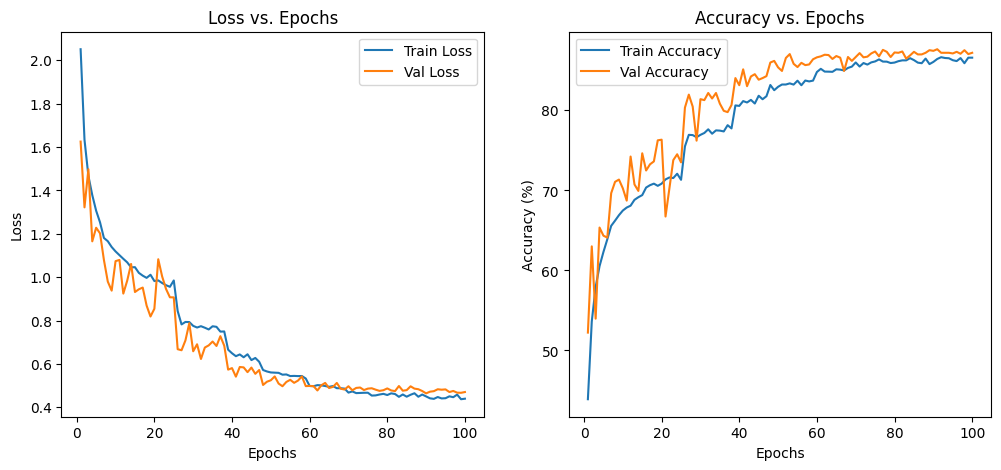

In [2]:
import matplotlib.pyplot as plt
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.savefig("ppfnet_train.png", dpi=300)
plt.show()